In [2]:
import os
import sys
import json
import requests as requests

from web3 import Web3, HTTPProvider

sys.path.append('../../../../../')

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

In [4]:
ALCHEMY_API_KEY = os.environ['ALCHEMY_API_KEY']
web3 = Web3(HTTPProvider(f"https://eth-mainnet.alchemyapi.io/v2/{ALCHEMY_API_KEY}"))

In [5]:
pool_addr = "0xD51a44d3FaE010294C616388b506AcdA1bfAAE46"
pool_token_addr = "0xc4AD29ba4B3c580e6D59105FFf484999997675Ff"
lp_token_price_oracle_addr = "0xE8b2989276E2Ca8FDEA2268E3551b2b4B2418950"
with open("./tricrypto2.json", 'r') as f:
    abi = json.load(f)
with open("./3crvcrypto_oracle.json", 'r') as f:
    abi_oracle = json.load(f)
contract = web3.eth.contract(address=pool_addr, abi=abi)
oracle = web3.eth.contract(address=lp_token_price_oracle_addr, abi=abi_oracle)

In [6]:
pool_token_addr.lower()

'0xc4ad29ba4b3c580e6d59105fff484999997675ff'

In [7]:
url = "https://api.thegraph.com/subgraphs/name/convex-community/crv-emissions"
# needs pool token addr and not pool addr:
query = '''
{
  poolSnapshots (
    where:{
      pool: "0xc4ad29ba4b3c580e6d59105fff484999997675ff"
    }
  )
  {
    fees
    block
  }
}
'''
r = requests.post(url, json={'query': query})
dict_response= dict(r.json())
df_subgraph_pool_data = pd.DataFrame(dict_response['data']['poolSnapshots'])
df_subgraph_pool_data['block'] = df_subgraph_pool_data.block.astype(int)
df_subgraph_pool_data['fees'] = df_subgraph_pool_data.fees.astype(float)
df_subgraph_pool_data.index = df_subgraph_pool_data.block
df_subgraph_pool_data

,block,fees
block,,
12874992,12874992,0.000000
12917964,12917964,-26250.762708
12961965,12961965,24342.224780
13007147,13007147,60563.719539
13052446,13052446,166746.475245
13097719,13097719,194427.725807
13142950,13142950,177009.724078
13189474,13189474,381457.789816
13233504,13233504,304706.989145


In [8]:
blocks = list([int(i) for i in df_subgraph_pool_data.block.values])
block_ranges = list(zip(blocks, blocks[1:]))
block_ranges

[(12874992, 12917964),
 (12917964, 12961965),
 (12961965, 13007147),
 (13007147, 13052446),
 (13052446, 13097719),
 (13097719, 13142950),
 (13142950, 13189474),
 (13189474, 13233504),
 (13233504, 13279324),
 (13279324, 13324114),
 (13324114, 13368595),
 (13368595, 13413314),
 (13413314, 13458926),
 (13458926, 13509655),
 (13509655, 13549403),
 (13549403, 13592432)]

In [9]:
admin_fee_claims = []
for (block_start, block_end) in block_ranges:

    # swaps:
    event_filter = contract.events.ClaimAdminFee.createFilter(
        fromBlock=block_start,
        toBlock=block_end
    )
    claim_admin_fee_events = event_filter.get_all_entries()
    for event in claim_admin_fee_events:
        tokens_claimed = event['args']['tokens'] * 1e-18
        block = event['blockNumber']

        admin_fee_claims.append(
            {
                'block': block,
                'tokens_claimed': tokens_claimed,
            }
        )


In [10]:
df_admin_fee_claims = pd.DataFrame(admin_fee_claims)
df_admin_fee_claims

,block,tokens_claimed
0,12890377,3.996017
1,12891715,0.232722
2,12900847,2.026368
3,12902512,0.456430
4,12902614,0.007752
...,...,...
212,13566044,6.346029
213,13572493,3.660431
214,13578840,7.479940
215,13585216,5.830637


Now need to query prices using oracle.

In [15]:
df_admin_fee_claims['oracle_price'] = 0
for idx, row in df_admin_fee_claims.iterrows():
    df_admin_fee_claims.loc[idx, 'computed_oracle_price'] = 0
    df_admin_fee_claims.loc[idx, 'queried_oracle_price'] = 0

    virtual_price = contract.functions.get_virtual_price().call(block_identifier=int(row.block)) * 1e-18
    oracle_price_btc = contract.functions.price_oracle(0).call(block_identifier=int(row.block)) * 1e-18
    oracle_price_eth = contract.functions.price_oracle(1).call(block_identifier=int(row.block)) * 1e-18

    # from contract: 0xE8b2989276E2Ca8FDEA2268E3551b2b4B2418950
    computed_lp_oracle_price = 3 * virtual_price * (oracle_price_btc * oracle_price_eth)**(1./3)
    try:
        queried_lp_oracle_price = oracle.functions.lp_price().call(block_identifier=int(row.block)) * 1e-18
    except Exception as err:  # contract did not exist and will return a BadFunctionCallOutput
        queried_lp_oracle_price = 0

    df_admin_fee_claims.loc[idx, 'computed_oracle_price'] = computed_lp_oracle_price
    df_admin_fee_claims.loc[idx, 'queried_oracle_price'] = queried_lp_oracle_price

df_admin_fee_claims

,block,tokens_claimed,oracle_price,computed_oracle_price,queried_oracle_price
0,12890377,3.996017,0,1268.580352,0.000000
1,12891715,0.232722,0,1260.640914,0.000000
2,12900847,2.026368,0,1336.914150,0.000000
3,12902512,0.456430,0,1348.746920,0.000000
4,12902614,0.007752,0,1349.752692,0.000000
...,...,...,...,...,...
212,13566044,6.346029,0,1961.616432,1959.855532
213,13572493,3.660431,0,1995.746156,1993.954618
214,13578840,7.479940,0,2059.215221,2057.366708
215,13585216,5.830637,0,2061.802392,2059.951557


In [16]:
df_admin_fee_claims['total_claimed_computed'] = (
        df_admin_fee_claims.tokens_claimed * df_admin_fee_claims.computed_oracle_price
)
df_admin_fee_claims['total_claimed_queried'] = (
        df_admin_fee_claims.tokens_claimed * df_admin_fee_claims.queried_oracle_price
)
df_admin_fee_claims

,block,tokens_claimed,oracle_price,computed_oracle_price,queried_oracle_price,total_claimed_computed,total_claimed_queried
0,12890377,3.996017,0,1268.580352,0.000000,5069.269047,0.000000
1,12891715,0.232722,0,1260.640914,0.000000,293.378410,0.000000
2,12900847,2.026368,0,1336.914150,0.000000,2709.080440,0.000000
3,12902512,0.456430,0,1348.746920,0.000000,615.609166,0.000000
4,12902614,0.007752,0,1349.752692,0.000000,10.463332,0.000000
...,...,...,...,...,...,...,...
212,13566044,6.346029,0,1961.616432,1959.855532,12448.474916,12437.300190
213,13572493,3.660431,0,1995.746156,1993.954618,7305.290173,7298.732373
214,13578840,7.479940,0,2059.215221,2057.366708,15402.806471,15388.979706
215,13585216,5.830637,0,2061.802392,2059.951557,12021.620947,12010.829399


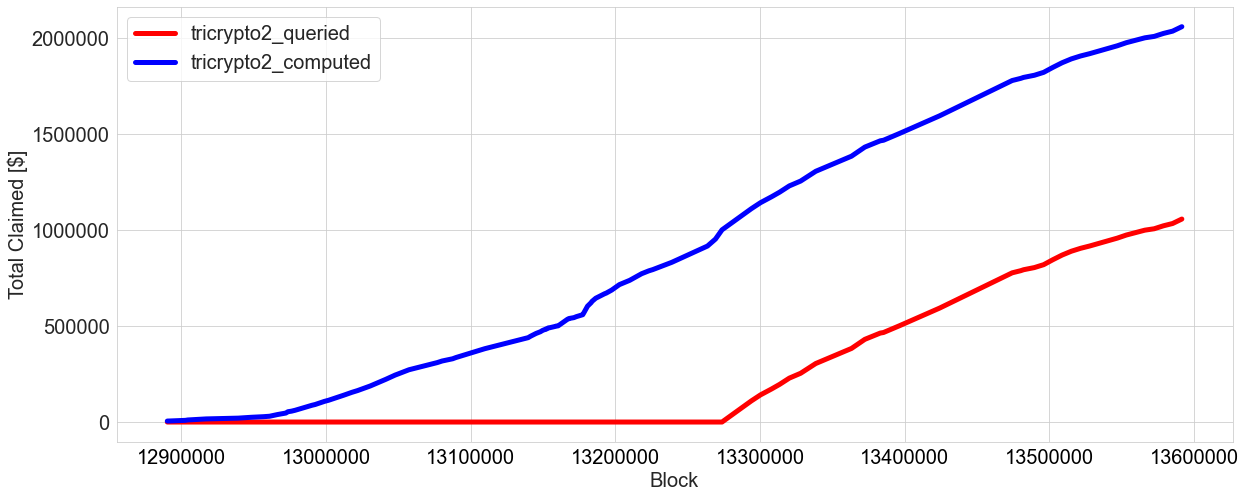

In [22]:
fig, ax = plt.subplots(1,1, figsize=(20, 8))

ax.plot(
    df_admin_fee_claims.block,
    df_admin_fee_claims.total_claimed_queried.cumsum(),
    color='red',
    lw=5,
    label='tricrypto2_queried'
)
ax.plot(
    df_admin_fee_claims.block,
    df_admin_fee_claims.total_claimed_computed.cumsum(),
    color='blue',
    lw=5,
    label='tricrypto2_computed'
)

ax.set_xlabel("Block", fontsize=20)
ax.set_ylabel("Total Claimed [$]", fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.tick_params(axis='x', which='major', colors='black')
ax.legend(fontsize=20)
ax.yaxis.get_major_formatter().set_scientific(False)
ax.yaxis.get_major_formatter().set_useOffset(False)
ax.xaxis.get_major_formatter().set_scientific(False)
ax.xaxis.get_major_formatter().set_useOffset(False)

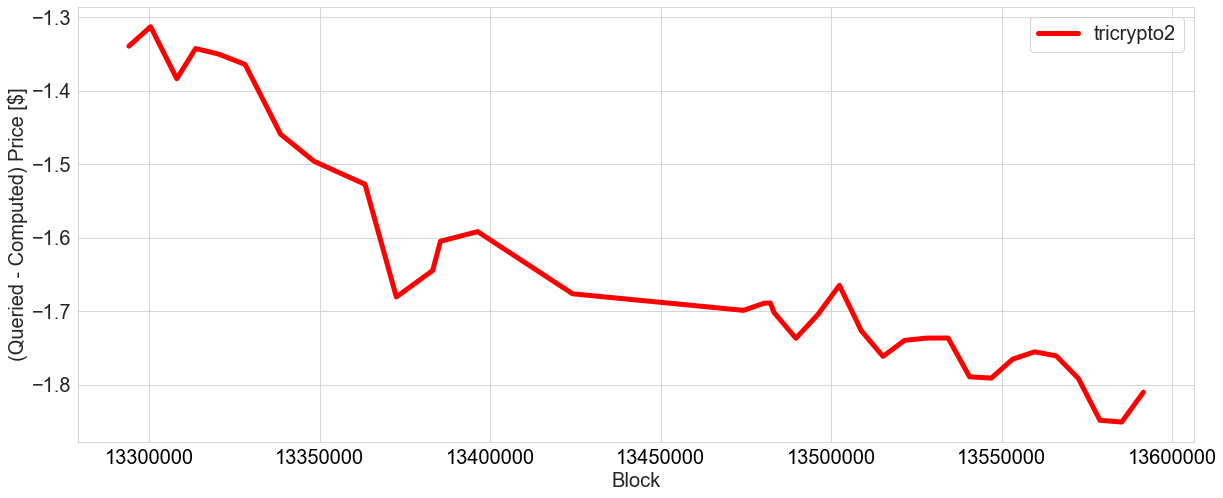

In [26]:
fig, ax = plt.subplots(1,1, figsize=(20, 8))

df_pruned = df_admin_fee_claims[df_admin_fee_claims.queried_oracle_price>0]

ax.plot(
    df_pruned.block,
    df_pruned.queried_oracle_price - df_pruned.computed_oracle_price,
    color='red',
    lw=5,
    label='tricrypto2'
)

ax.set_xlabel("Block", fontsize=20)
ax.set_ylabel("(Queried - Computed) Price [$]", fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.tick_params(axis='x', which='major', colors='black')
ax.legend(fontsize=20)
ax.yaxis.get_major_formatter().set_scientific(False)
ax.yaxis.get_major_formatter().set_useOffset(False)
ax.xaxis.get_major_formatter().set_scientific(False)
ax.xaxis.get_major_formatter().set_useOffset(False)

Query crv-emissions subgraph:

In [27]:
"0xc4AD29ba4B3c580e6D59105FFf484999997675Ff".lower()  # subgraph only accepts lowercase: this is the tricrypto lp token

'0xc4ad29ba4b3c580e6d59105fff484999997675ff'

In [33]:
url = "https://api.thegraph.com/subgraphs/name/convex-community/crv-emissions"
# needs pool token addr and not pool addr:
query = '''
{
  poolSnapshots (
    where:{
      pool: "0xc4ad29ba4b3c580e6d59105fff484999997675ff"
    }
  )
  {
    fees
    block
  }
}
'''
r = requests.post(url, json={'query': query})
dict_response= dict(r.json())
df_subgraph_pool_data = pd.DataFrame(dict_response['data']['poolSnapshots'])
df_subgraph_pool_data['block'] = df_subgraph_pool_data.block.astype(int)
df_subgraph_pool_data['fees'] = df_subgraph_pool_data.fees.astype(float)
df_subgraph_pool_data.index = df_subgraph_pool_data.block
df_subgraph_pool_data

,block,fees
block,,
12874992,12874992,0.000000
12917964,12917964,-26250.762708
12961965,12961965,24342.224780
13007147,13007147,60563.719539
13052446,13052446,166746.475245
13097719,13097719,194427.725807
13142950,13142950,177009.724078
13189474,13189474,381457.789816
13233504,13233504,304706.989145


Aggregate claim fee events to blocks:

In [34]:
blocks = list([int(i) for i in df_subgraph_pool_data.block.values])
block_ranges = list(zip(blocks, blocks[1:]))
block_ranges

[(12874992, 12917964),
 (12917964, 12961965),
 (12961965, 13007147),
 (13007147, 13052446),
 (13052446, 13097719),
 (13097719, 13142950),
 (13142950, 13189474),
 (13189474, 13233504),
 (13233504, 13279324),
 (13279324, 13324114),
 (13324114, 13368595),
 (13368595, 13413314),
 (13413314, 13458926),
 (13458926, 13509655),
 (13509655, 13549403),
 (13549403, 13592432)]

In [39]:
aggregated_claims = []
blocks = []
for (block_start, block_end) in block_ranges:

    aggregated_claims.append(
        df_admin_fee_claims.total_claimed_computed.where(
            (block_start < df_admin_fee_claims.block) & (df_admin_fee_claims.block < block_end)
        ).sum()
    )
    blocks.append(block_end)

aggregated_claims

[16259.570206409244,
 13900.41136913996,
 83454.87735783325,
 137181.88958161755,
 85483.61441534877,
 110925.74756103317,
 198036.69579874206,
 149276.9202044636,
 207207.73332213517,
 229105.71449419417,
 154896.00037160527,
 118061.49864156253,
 92399.36517606326,
 276649.15591150126,
 88379.72302551955,
 99530.52745843228]

In [41]:
df_aggregated_claims = pd.DataFrame(data=aggregated_claims, index=blocks, columns=['claimed'])
df_aggregated_claims

,claimed
12917964,16259.570206
12961965,13900.411369
13007147,83454.877358
13052446,137181.889582
13097719,85483.614415
13142950,110925.747561
13189474,198036.695799
13233504,149276.920204
13279324,207207.733322
13324114,229105.714494


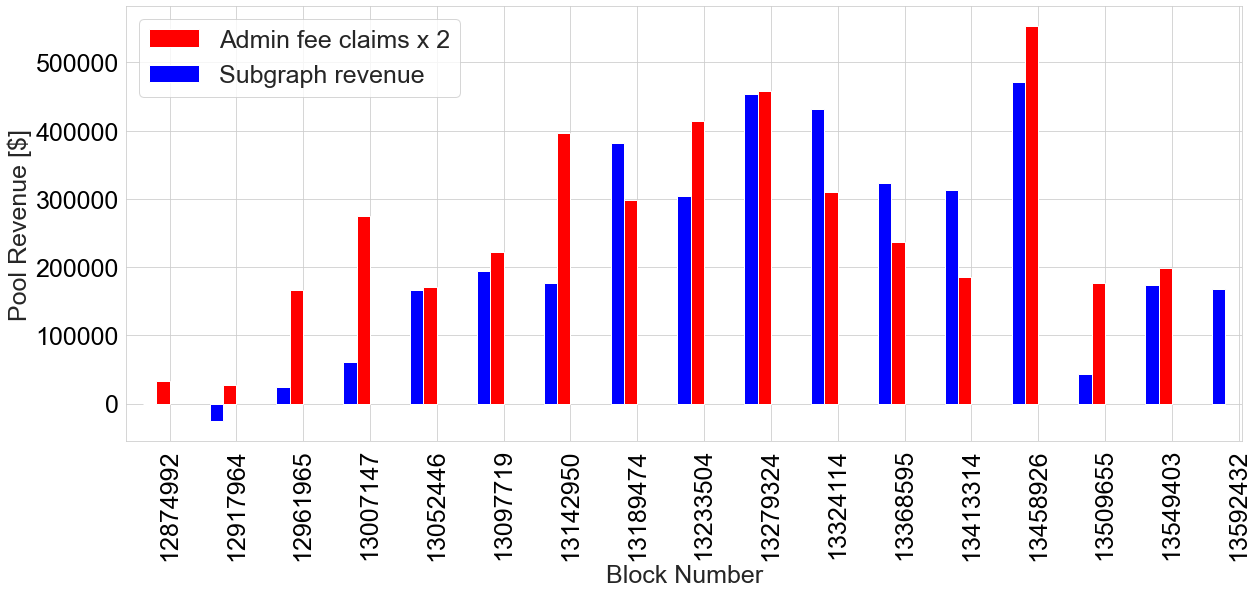

In [45]:
fig, ax = plt.subplots(1,1, figsize=(20, 8))

(df_aggregated_claims['claimed']*2).plot(
    ax=ax,
    color='red',
    kind='bar',
    label='Admin fee claims x 2',
    width=0.2,
    position=1,
)
df_subgraph_pool_data['fees'].plot(
    ax=ax,
    color='blue',
    kind='bar',
    label='Subgraph revenue',
    width=0.2,
    position=2,
)

ax.set_ylabel("Pool Revenue [$]", fontsize=25)
ax.set_xlabel("Block Number", fontsize=25)
ax.tick_params(axis='both', which='major', labelsize=25, colors='black')
ax.yaxis.get_major_formatter().set_scientific(False)
ax.yaxis.get_major_formatter().set_useOffset(False)
ax.legend(fontsize=25);

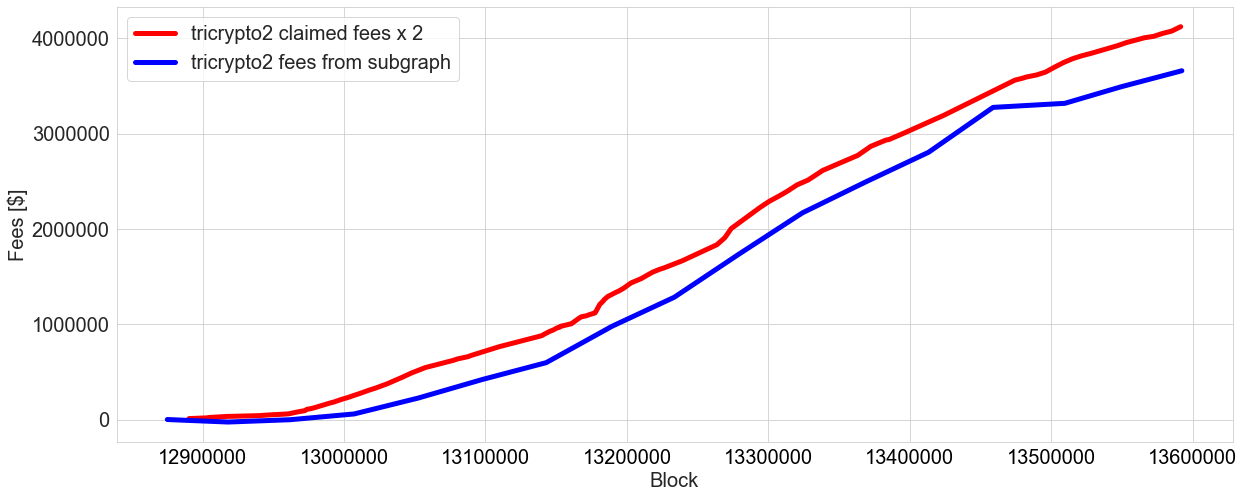

In [47]:
fig, ax = plt.subplots(1,1, figsize=(20, 8))

ax.plot(
    df_admin_fee_claims.block,
    df_admin_fee_claims.total_claimed_computed.cumsum() * 2,
    color='red',
    lw=5,
    label='tricrypto2 claimed fees x 2'
)

ax.plot(
    df_subgraph_pool_data.block,
    df_subgraph_pool_data.fees.cumsum(),
    color='blue',
    lw=5,
    label='tricrypto2 fees from subgraph'
)


ax.set_xlabel("Block", fontsize=20)
ax.set_ylabel("Fees [$]", fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.tick_params(axis='x', which='major', colors='black')
ax.legend(fontsize=20)
ax.yaxis.get_major_formatter().set_scientific(False)
ax.yaxis.get_major_formatter().set_useOffset(False)
ax.xaxis.get_major_formatter().set_scientific(False)
ax.xaxis.get_major_formatter().set_useOffset(False)